In [316]:
%matplotlib inline
import cd_diagrams as cdd
import importlib
import pandas as pd
import numpy as np
import amir_tools as at
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import functools as ft
import matplotlib
import warnings
matplotlib.rc_file_defaults()
datasets = ["ChapmanShaoxing","CPSC2018","PTBXL"]
models = ["inception","minirocket","xresnet1d101"]

In [300]:
def get_scaling_experiments(model_name,dataset,clf_numbers=True,dataset_numbers=True):
    # loads the experiment results
    experiments = []
    for sc in ["0.1","0.25","0.5","0.75","1.0"]:
        try:
            for i in range(20):
                df = pd.read_csv("models/scaling/csvs/%s_%s_sc-n_%s_%s.csv"%(model_name,dataset,sc,i))
                df = df[df.columns[0:-4]]
                df = df.loc[df["index"]=="f1-score"]
                df = df.rename(columns={"index":"classifier_name"})
                df["classifier_name"] = model_name if clf_numbers==False else "%s_%s"%(model_name,sc)
                df["dataset_name"] = dataset if dataset_numbers==False else "%s_%s"%(dataset,i)
                df.index = [i]
                experiments.append(df)
        except Exception as  e:
            print(e)
            continue
    exp_df = pd.concat(experiments)
    return exp_df

def make_cdd_df(exp_df):
    df_median = exp_df.reset_index()[["classifier_name","dataset_name",]]
    df_median["value"] = list(exp_df[exp_df.columns[1:-1]].mean(axis=1).values)
    df_median.columns = ["classifier_name","dataset_name","accuracy"]
    return df_median

def cd_diagram_single_model(exp_df,title="Mean F1",labels=False):
    df_median = make_cdd_df(exp_df)
    cdd.draw_cd_diagram(df_perf=df_median, title=title, labels=labels,alpha=0.05)
    
def draw_scatter_plot(exp_df):
    sns.set(rc = {'figure.figsize':(10,6)})
    sns.set(font_scale = 2)
    data = exp_df.melt(id_vars = "classifier_name")
    data["variable"] = [at.label_shortner(x) for x in data["variable"]]

    #sns.boxplot(data=data,hue="classifier_name",x="variable",y="value",)
    ax = sns.stripplot(data=data,hue="classifier_name",x="variable",y="value",dodge=True,size=8, edgecolor='gray',)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=20,rotation=45)
    ax.set_xlabel("", fontsize = 25)
    ax.set_ylabel("F1 Values", fontsize = 25)
    # ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)
#     plt.legend( fontsize = 16)
#     plt.tight_layout()
    return plt

## per model analysis

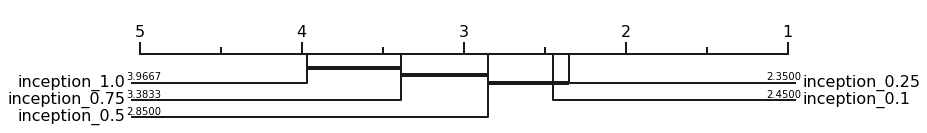

In [357]:
datasets = ["ChapmanShaoxing","CPSC2018","PTBXL"]
inception_dfs = []
for dataset in datasets:
    model_name = "inception"
    exp_df = get_scaling_experiments(model_name,dataset)
    inception_dfs.append(exp_df)
df_inception = pd.concat([make_cdd_df(x) for x in inception_dfs])
plt = cdd.draw_cd_diagram(df_perf=df_inception,alpha=0.05,labels=True)

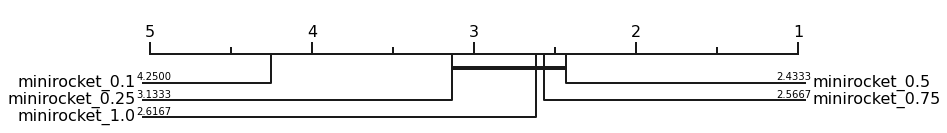

In [358]:
minirocket_dfs = []
for dataset in datasets:
    model_name = "minirocket"
    exp_df = get_scaling_experiments(model_name,dataset)
    minirocket_dfs.append(exp_df)
df_minirocket = pd.concat([make_cdd_df(x) for x in minirocket_dfs])
plt = cdd.draw_cd_diagram(df_perf=df_minirocket,alpha=0.05,labels=True)

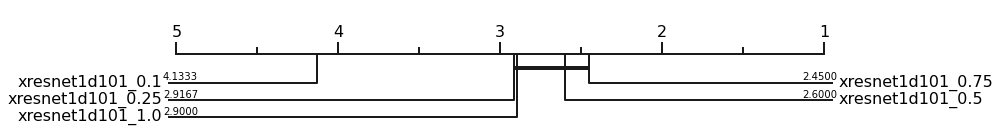

In [359]:
xresnet_dfs = []
for dataset in datasets:
    model_name = "xresnet1d101"
    exp_df = get_scaling_experiments(model_name,dataset)
    xresnet_dfs.append(exp_df)
df_xresnet = pd.concat([make_cdd_df(x) for x in xresnet_dfs])
plt = cdd.draw_cd_diagram(df_perf=df_xresnet,alpha=0.05,labels=True)

## per dataset analysis
- classifier_names = model_HZ
- dataset name = datset + bootstrap#
- accuracy = F1

<AxesSubplot:>

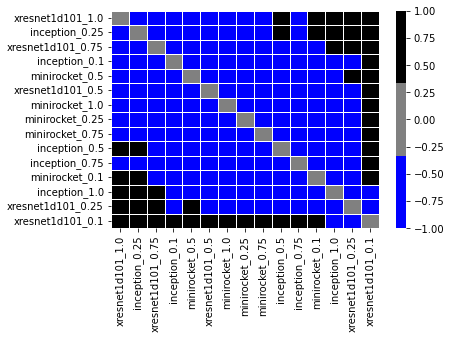

In [466]:
dataset = "ChapmanShaoxing"
dataset_dfs = []
for model_name in models[0:3]:
    exp_df = get_scaling_experiments(model_name,dataset)
    dataset_dfs.append(exp_df)
p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
# given a model, find whether it's significantly better than the one ranked below it
m_list = list(avg_rank.index)  #sorted list of models by avg rank
p_vals = pd.DataFrame(p_vals)
# make a matrix of which models is significantly better than the others
rank_matrix = pd.DataFrame(-1*np.ones([len(m_list),len(m_list)]),index=reversed(m_list),columns=reversed(m_list))
i = 0
for m1 in m_list:
    for m2 in list(reversed(m_list)):
        row = p_vals[((p_vals[0]==m1) & (p_vals[1]==m2)) | (p_vals[1]==m1) & (p_vals[0]==m2)]
        if row.shape[0]>0:
            if row[3].values[0] == True:
                rank_matrix.loc[m1][m2] = 1
        else: 
            rank_matrix.loc[m1][m2] = 0
sns.heatmap(rank_matrix, cmap=["blue","grey","black"], linewidths=0.5,)

# per disease analysis

In [375]:
# first, select a dataset
# treat each disease as its own dataset, and run the cd analysis for all models. 
# classifier_name -> model+sc
# dataset_name -> disease+dataset (in case there are duplicates)
# acc -> F1 measure

<AxesSubplot:>

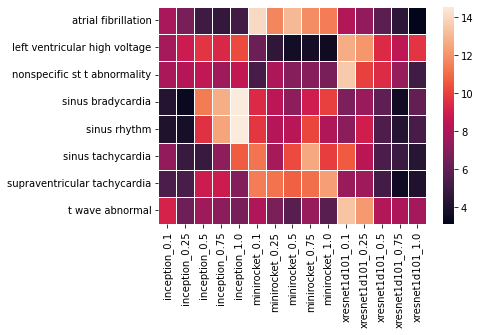

In [477]:
dset_num = 0 # 0->chapman,1->cpsc, 2->ptbxl
disease_list = minirocket_dfs[dset_num].columns[1:-1]
dataset_dfs = []
df = pd.concat([minirocket_dfs[dset_num],inception_dfs[dset_num],xresnet_dfs[dset_num]]) 
# now for each disease in disease_list, do the analysis
disease_dict = {}
for disease_name in disease_list:
    df_perf = df[["classifier_name","dataset_name",disease_name]]
    df_perf = df_perf.rename(columns={disease_name:"accuracy"})
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        disease_dict[disease_name] = cdd.wilcoxon_holm(df_perf=df_perf, alpha=0.05)[1]
sns.heatmap(pd.DataFrame(disease_dict).T, linewidths=0.5,)

In [ ]:
df_melt = pd.melt(df,id_vars=["classifier_name"],value_vars=df.columns[1:-1],var_name="dataset_name",value_name="accuracy")

cdd.draw_cd_diagram(df_perf=df_melt,alpha=0.05,labels=True)

0       atrial fibrillation
1       atrial fibrillation
2       atrial fibrillation
3       atrial fibrillation
4       atrial fibrillation
               ...         
2395        t wave abnormal
2396        t wave abnormal
2397        t wave abnormal
2398        t wave abnormal
2399        t wave abnormal
Name: dataset_name, Length: 2400, dtype: object

## all models, all datasets
- classifier_names = model_HZ
- dataset name = datset + bootstrap#
- accuracy = F1

<AxesSubplot:>

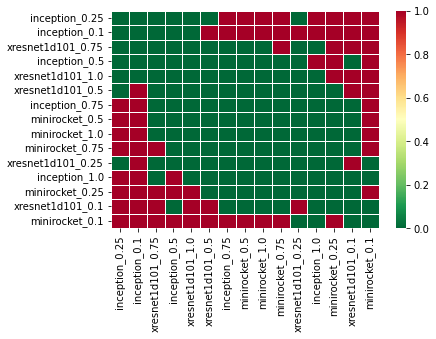

In [446]:
dataset_dfs = []
for model_name in models[0:3]:
    for dataset in datasets[0:]:
        exp_df = get_scaling_experiments(model_name,dataset)
        dataset_dfs.append(exp_df)
p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
# given a model, find whether it's significantly better than the one ranked below it
m_list = list(avg_rank.index)  #sorted list of models by avg rank
p_vals = pd.DataFrame(p_vals)
# make a matrix of which models is significantly better than the others
rank_matrix = pd.DataFrame(np.zeros([len(m_list),len(m_list)]),index=reversed(m_list),columns=reversed(m_list))
i = 0
for m1 in m_list:
    for m2 in list(reversed(m_list)):
        row = p_vals[((p_vals[0]==m1) & (p_vals[1]==m2)) | (p_vals[1]==m1) & (p_vals[0]==m2)]
        if row.shape[0]>0:
            if row[3].values[0] == True:
                rank_matrix.loc[m1][m2] = 1
        else: 
            rank_matrix.loc[m1][m2] = 0
sns.heatmap(rank_matrix, cmap='RdYlGn_r', linewidths=0.5,)

In [ ]:
dataset = "PTBXL"
dataset_dfs = []
for model_name in models[0:3]:
    exp_df = get_scaling_experiments(model_name,dataset)
    dataset_dfs.append(exp_df)
# plt,p_vals,avg_rank = cdd.draw_cd_diagram(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]),alpha=0.05,labels=True)
p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
# given a model, find whether it's significantly better than the one ranked below it
m_list = list(avg_rank.index)  #sorted list of models by avg rank
p_vals = pd.DataFrame(p_vals)
# make a matrix of which models is significantly better than the others
rank_matrix = pd.DataFrame(np.zeros([len(m_list),len(m_list)]),index=reversed(m_list),columns=reversed(m_list))
i = 0
for m1 in m_list:
    for m2 in list(reversed(m_list)):
        row = p_vals[((p_vals[0]==m1) & (p_vals[1]==m2)) | (p_vals[1]==m1) & (p_vals[0]==m2)]
        if row.shape[0]>0:
            if row[3].values[0] == True:
                rank_matrix.loc[m1][m2] = 1
        else: 
            rank_matrix.loc[m1][m2] = 0
plt.show()
sns.heatmap(rank_matrix, cmap='RdYlGn_r', linewidths=0.5,)

# other stuff

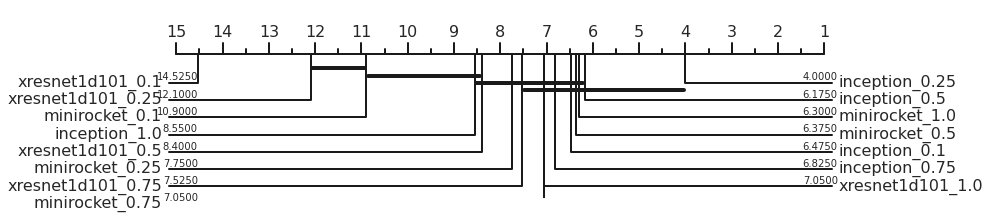

In [113]:
importlib.reload(cdd)
df_perf = pd.concat([df_xresnet,df_inception,df_minirocket])
plt,p_vals,avg_rank = cdd.draw_cd_diagram(df_perf=df_perf,alpha=0.05,labels=True,)

In [124]:
stats = pd.DataFrame(p_vals,columns=["model_1","model_2","p_val","significant"])
# stats[(stats["model_1"]=="inception_1.0")]
avg_rank

xresnet1d101_0.1     14.525
xresnet1d101_0.25    12.100
minirocket_0.1       10.900
inception_1.0         8.550
xresnet1d101_0.5      8.400
minirocket_0.25       7.750
xresnet1d101_0.75     7.525
minirocket_0.75       7.050
xresnet1d101_1.0      7.050
inception_0.75        6.825
inception_0.1         6.475
minirocket_0.5        6.375
minirocket_1.0        6.300
inception_0.5         6.175
inception_0.25        4.000
dtype: float64

# scatter plots

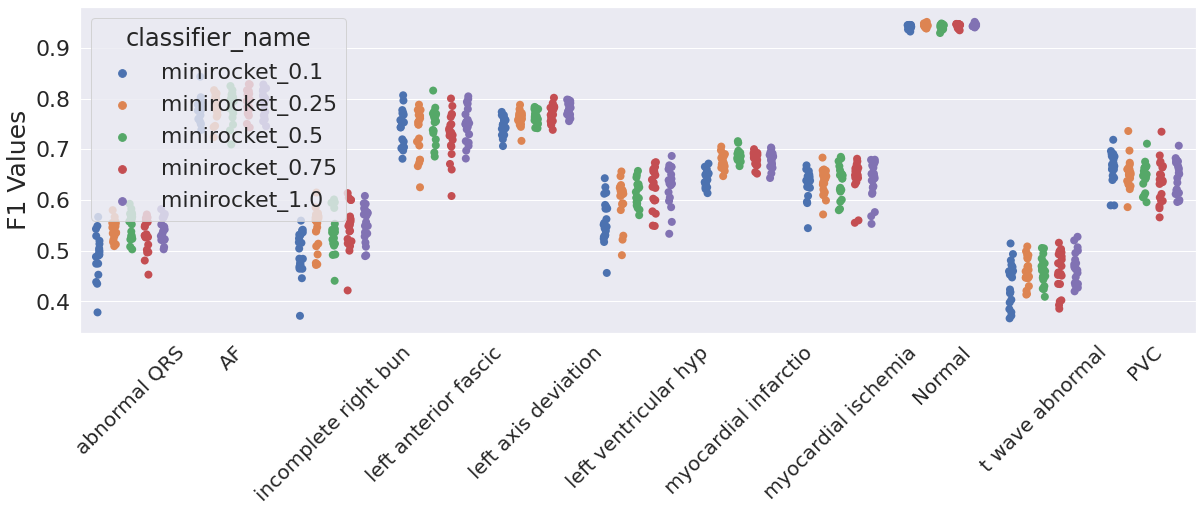

In [104]:
for dataset in datasets:
    model_name = "minirocket"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
# ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

[Errno 2] No such file or directory: 'models/scaling/csvs/xresnet1d101_CPSC2018_sc-n_0.1_16.csv'
[Errno 2] No such file or directory: 'models/scaling/csvs/xresnet1d101_CPSC2018_sc-n_0.25_0.csv'
[Errno 2] No such file or directory: 'models/scaling/csvs/xresnet1d101_CPSC2018_sc-n_0.5_13.csv'
[Errno 2] No such file or directory: 'models/scaling/csvs/xresnet1d101_CPSC2018_sc-n_0.75_18.csv'


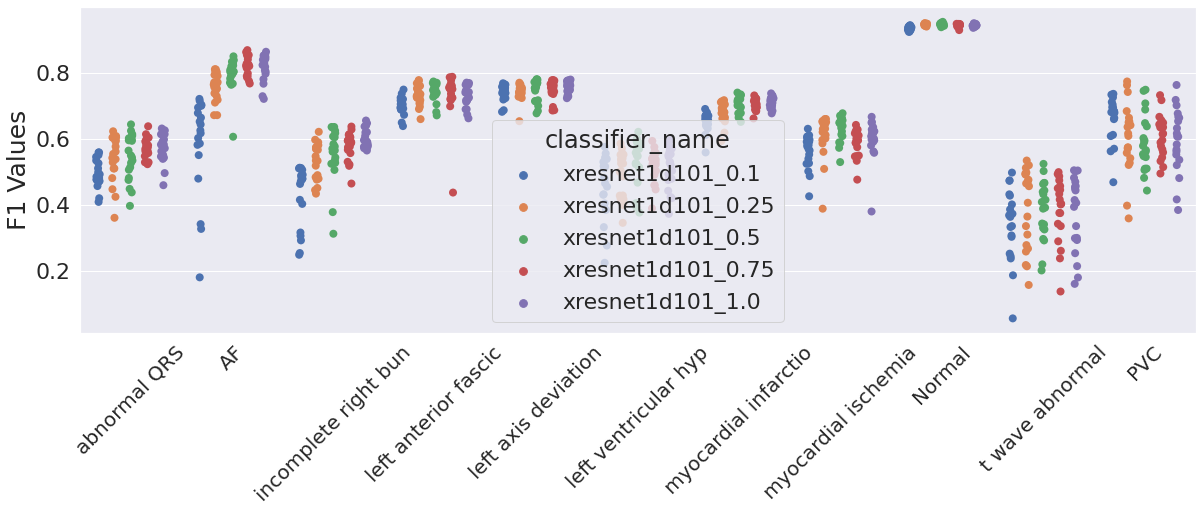

In [105]:
for dataset in datasets:
    model_name = "xresnet1d101"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
# ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

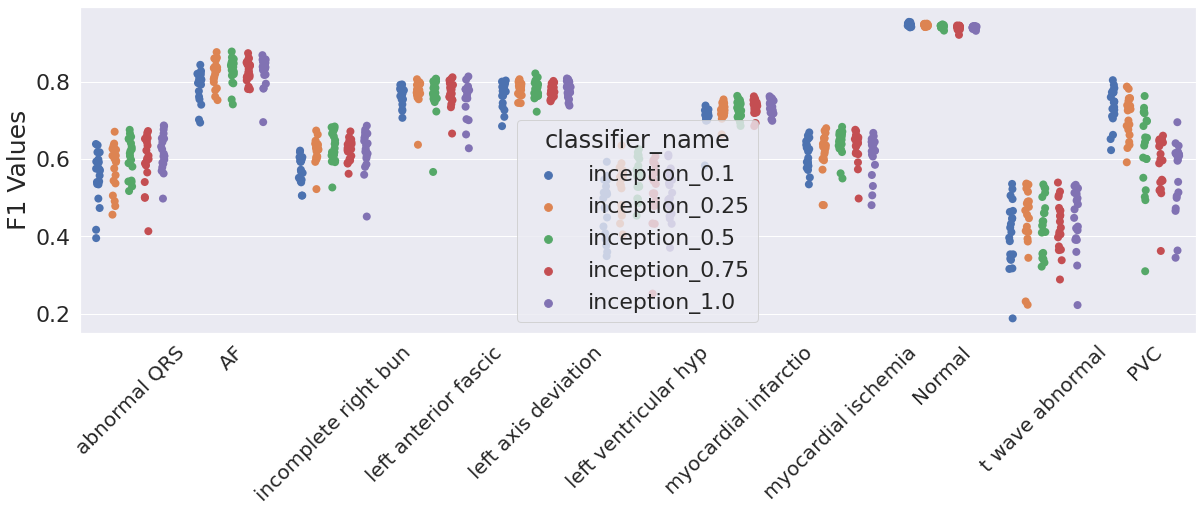

In [106]:
for dataset in datasets:
    model_name = "inception"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
# ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

In [102]:
# compare inception and xresnet ( or any two models)
model_1 = "inception"
model_2 = "xresnet1d101"
exp_1 = get_scaling_experiments(model_1,dataset,dataset_numbers=False).drop(columns=["dataset_name"]).groupby("classifier_name").median()
exp_2 = get_scaling_experiments(model_2,dataset,dataset_numbers=False).drop(columns=["dataset_name"]).groupby("classifier_name").median()


In [103]:
# get difference between the 20 model experiments for each disease
pd.DataFrame(exp_2.values-exp_1.values,columns = exp_1.columns,index=[int(np.float32(x.split("_")[1])*500) for x in exp_1.index])

,abnormal QRS,atrial fibrillation,incomplete right bundle branch block,left anterior fascicular block,left axis deviation,left ventricular hypertrophy,myocardial infarction,myocardial ischemia,sinus rhythm,t wave abnormal,ventricular ectopics
50,-0.087908,-0.169038,-0.104308,-0.068199,-0.031581,-0.023549,-0.055027,-0.033129,-0.014154,-0.051400,-0.065706
125,-0.040984,-0.065734,-0.086180,-0.040735,-0.039938,-0.029012,-0.045959,-0.004005,-0.002055,-0.030761,-0.115769
250,-0.065410,-0.035533,-0.066724,-0.024761,-0.021755,-0.008554,-0.018887,-0.007129,0.002195,-0.034690,-0.077808
375,-0.020832,-0.007321,-0.041080,-0.022351,-0.022951,-0.009252,-0.034420,-0.044967,0.002015,-0.028257,0.016687
500,-0.040844,-0.010510,-0.038894,-0.037485,-0.027322,0.031746,-0.034012,-0.010982,0.003128,-0.049314,0.003131
